# Multi-modal vector embeddings

A vector embedding can also represent non-textual data, such as images.

In [ ]:
import os

import requests
from PIL import Image
import dotenv

dotenv.load_dotenv()

# API Key authentication
AZURE_AIVISION_API_KEY = ""
AZURE_COMPUTER_VISION_URL = f"https://multimodalaiservice.cognitiveservices.azure.com/"

def get_model_params():
    return {"api-version": "2024-02-01", "model-version": "2023-04-15"}

def get_auth_headers():
    return {"Ocp-Apim-Subscription-Key": AZURE_AIVISION_API_KEY}

def get_image_embedding(image_file):
    url = f"{AZURE_COMPUTER_VISION_URL}/computervision/retrieval:vectorizeImage"
    headers = get_auth_headers()
    headers["Content-Type"] = "application/octet-stream"
    
    # Read the image file as binary data and send directly
    with open(image_file, "rb") as image_data:
        response = requests.post(url, headers=headers, params=get_model_params(), data=image_data)
    
    if response.status_code != 200:
        print(image_file, response.status_code, response.json())
    return response.json()["vector"]


In [ ]:
import json

vectors = {}
for image_file in os.listdir("./data"):
    # Filter only .png files (case-insensitive)
    if image_file.lower().endswith('.png'):
        image_path = f"./data/{image_file}"
        try:
            image_embedding = get_image_embedding(image_path)
            vectors[image_file] = image_embedding
            print(f"✓ Processed: {image_file}")
        except Exception as e:
            print(f"✗ Error with {image_file}: {e}")

# save the embeddings to a file
with open("./data/images_ai-vision.json", "w") as f:
    json.dump(vectors, f)
    

✓ Procesada: shoeFactory2.png
✓ Procesada: planeMotor2.png
✓ Procesada: planeMotor3.png
✓ Procesada: planeWing4.png
✓ Procesada: planeWing2.png
✓ Procesada: planeWing.png
✓ Procesada: shoeFactory3.png
✓ Procesada: planeMotor.png
✓ Procesada: planeWing3.png
✓ Procesada: shoeFactory.png


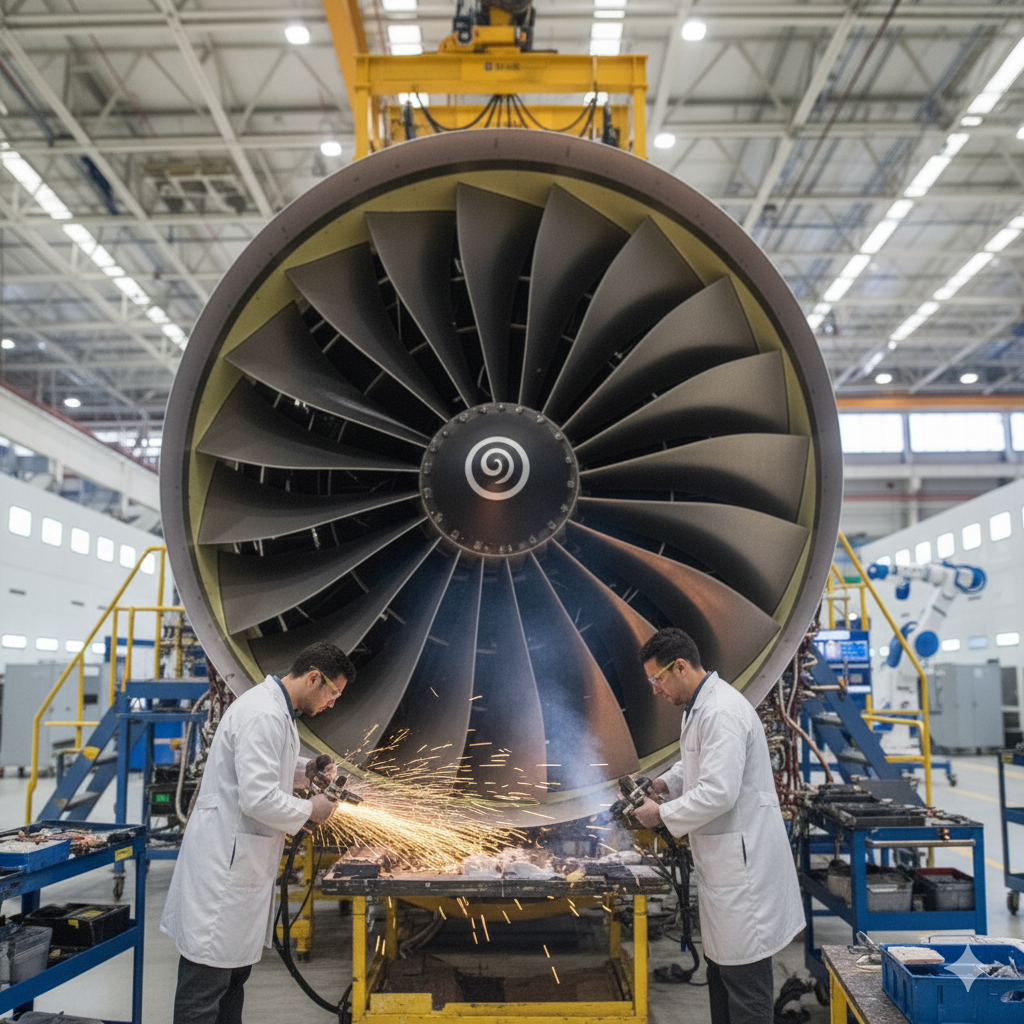

In [3]:
Image.open("./data/planeMotor.png")

In [4]:
vectors["planeMotor.png"]

[0.8149414,
 -1.1347656,
 0.43115234,
 1.2958984,
 0.47875977,
 0.2565918,
 -0.39160156,
 -0.8378906,
 -2.2910156,
 -0.95654297,
 0.18615723,
 -0.15209961,
 0.6923828,
 -0.9604492,
 -0.42041016,
 -5.6367188,
 2.8417969,
 -1.9443359,
 1.4462891,
 -0.9067383,
 0.25683594,
 1.5478516,
 1.125,
 0.49804688,
 1.5136719,
 1.0791016,
 -51.5,
 0.030899048,
 -0.7705078,
 -0.7714844,
 -2.1992188,
 -2.4140625,
 1.5351562,
 -0.5185547,
 -0.2043457,
 -1.2519531,
 2.6621094,
 -0.9794922,
 -1.1367188,
 -2.3652344,
 1.6015625,
 -0.064941406,
 1.1054688,
 -0.86035156,
 0.17016602,
 -0.43408203,
 -0.62109375,
 2.6757812,
 0.5029297,
 -1.9697266,
 -0.5595703,
 0.56152344,
 -0.89941406,
 3.5039062,
 0.0803833,
 0.5048828,
 1.1582031,
 -1.2304688,
 -2.5371094,
 2.7148438,
 0.41064453,
 2.9609375,
 1.6503906,
 -1.0830078,
 0.43115234,
 0.60009766,
 -2.3496094,
 2.2988281,
 0.32128906,
 3.1503906,
 0.82666016,
 0.22631836,
 1.2324219,
 0.044189453,
 1.5039062,
 0.5214844,
 -0.88378906,
 1.9560547,
 -0.4873047

In [5]:
len(vectors["planeMotor.png"])

1024

# Multi-modal Vectors Analysis

These vectors come from the Azure AI Vision multimodal embedding model, which can represent both text and images in a 1024-dimensional space.


In [ ]:
with open('./data/images_ai-vision.json') as f:
    image_vectors = json.load(f)


In [ ]:
import random
import matplotlib.pyplot as plt

random_image_name = random.choice(list(image_vectors.keys()))
vector = image_vectors[random_image_name]

plt.bar(range(len(vector)), vector)
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.show()


## Most similar to a target image


In [ ]:
import pandas as pd

def cosine_similarity(v1, v2):
    """Calculate the cosine similarity between two vectors"""
    dot_product = sum([a * b for a, b in zip(v1, v2)])
    magnitude = (sum([a**2 for a in v1]) * sum([a**2 for a in v2])) ** 0.5
    return dot_product / magnitude

def most_similar(target_vector: str, vectors: dict) -> list[list]:
    """Return the most similar images and their similarities relative to the given images"""
    similarities = {w: cosine_similarity(target_vector, vector) for w, vector in vectors.items()}
    most_similar = sorted(similarities, key=similarities.get, reverse=True)
    return pd.DataFrame([(vector_key, similarities[vector_key]) for vector_key in most_similar], columns=['vector key', 'similarity'])


In [ ]:
# Render the target image
target_image = "planeMotor.png"
plt.imshow(plt.imread(f"./data/{target_image}"))


In [ ]:
most_similar_df = most_similar(image_vectors[target_image], image_vectors)[0:3]
most_similar_df


In [ ]:
# Now render each of those images
for image_name in most_similar_df['vector key'][1:]:
    plt.imshow(plt.imread(f'./data/{image_name}'))
    plt.axis('off')
    plt.show()


## Search with query vectors


In [ ]:
def get_text_embedding(text):
    url = f"{AZURE_COMPUTER_VISION_URL}/computervision/retrieval:vectorizeText"
    headers = get_auth_headers()
    headers["Content-Type"] = "application/json"
    return requests.post(url, headers=headers, params=get_model_params(),
                         json={"text": text}).json()["vector"]


In [ ]:
embedding = get_text_embedding("Wing") # Examples: "Motor" "Shoe" "Plane"
most_similar_df = most_similar(embedding, image_vectors)

for image_name in most_similar_df['vector key'][0:3]:
    plt.imshow(plt.imread(f'./data/{image_name}'))
    plt.axis('off')
    plt.show()
